# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# from sklearn.preprocessing import Imputer
#from sklearn.impute import SimpleImputer as Imputer


# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
'''
Compare columns with few null values:
ALTERSKATEGORIE_GROB (Estimated age)
ANREDE_KZ (gender)
FINANZTYP (financial type for individual)
HH_EINKOMMEN_SCORE (Estimated household net income)
LP_STATUS_FEIN (Social status, fine scale)
'''

'\nCompare columns with few null values:\nALTERSKATEGORIE_GROB (Estimated age)\nANREDE_KZ (gender)\nFINANZTYP (financial type for individual)\nHH_EINKOMMEN_SCORE (Estimated household net income)\nLP_STATUS_FEIN (Social status, fine scale)\n'

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
temp1 = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
temp1

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [4]:
temp2= pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
temp2

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [5]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# azdias.to_csv('start_azdias.csv',sep='\t')
# customers.to_csv('start_customers.csv',sep='\t')

In [7]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [8]:
#! conda install mxnet --yes

In [9]:
azdias.columns.values

array(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
       'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST',
       'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG',
       'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DA

In [10]:
customers.columns.values

array(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
       'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST',
       'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG',
       'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DA

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [11]:
cols=['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']
for col in cols :
    print(col)
    print(customers[col].value_counts(normalize=True))
    
#customers.drop(columns=cols,inplace=True)   

PRODUCT_GROUP
COSMETIC_AND_FOOD    0.526266
FOOD                 0.247229
COSMETIC             0.226504
Name: PRODUCT_GROUP, dtype: float64
CUSTOMER_GROUP
MULTI_BUYER     0.68999
SINGLE_BUYER    0.31001
Name: CUSTOMER_GROUP, dtype: float64
ONLINE_PURCHASE
0    0.909753
1    0.090247
Name: ONLINE_PURCHASE, dtype: float64


In [12]:
customers.ALTER_HH.value_counts()

0.0     22151
10.0    14488
9.0     12976
11.0     9009
21.0     8503
8.0      8111
16.0     8011
12.0     7779
15.0     7737
17.0     7332
20.0     6554
18.0     6450
14.0     6192
13.0     6164
19.0     6136
7.0      5307
6.0      1848
5.0       228
4.0        52
3.0        15
2.0        13
Name: ALTER_HH, dtype: int64

In [13]:
customers.dtypes, azdias.dtypes

(LNR                             int64
 AGER_TYP                        int64
 AKT_DAT_KL                    float64
 ALTER_HH                      float64
 ALTER_KIND1                   float64
 ALTER_KIND2                   float64
 ALTER_KIND3                   float64
 ALTER_KIND4                   float64
 ALTERSKATEGORIE_FEIN          float64
 ANZ_HAUSHALTE_AKTIV           float64
 ANZ_HH_TITEL                  float64
 ANZ_KINDER                    float64
 ANZ_PERSONEN                  float64
 ANZ_STATISTISCHE_HAUSHALTE    float64
 ANZ_TITEL                     float64
 ARBEIT                        float64
 BALLRAUM                      float64
 CAMEO_DEU_2015                 object
 CAMEO_DEUG_2015                object
 CAMEO_INTL_2015                object
 CJT_GESAMTTYP                 float64
 CJT_KATALOGNUTZER             float64
 CJT_TYP_1                     float64
 CJT_TYP_2                     float64
 CJT_TYP_3                     float64
 CJT_TYP_4               

In [14]:
check = len(set(azdias.columns.values).intersection(set(customers.columns.values)))
if (check==366):
    print('Confirmation that Customers and Azdias DataFrame has\
    same number of cols except 3 in customers as expected')

Confirmation that Customers and Azdias DataFrame has    same number of cols except 3 in customers as expected


In [15]:
customers.shape[0],azdias.shape[0]

(191652, 891221)

In [16]:
customers.AGER_TYP.value_counts()

-1    92107
 2    45874
 1    40382
 3     8658
 0     4631
Name: AGER_TYP, dtype: int64

In [17]:
'''Checking sparsity in columns'''
customers.isna().sum()/customers.shape[0]

LNR                           0.000000
AGER_TYP                      0.000000
AKT_DAT_KL                    0.243128
ALTER_HH                      0.243128
ALTER_KIND1                   0.938607
ALTER_KIND2                   0.973389
ALTER_KIND3                   0.993347
ALTER_KIND4                   0.998769
ALTERSKATEGORIE_FEIN          0.270501
ANZ_HAUSHALTE_AKTIV           0.260509
ANZ_HH_TITEL                  0.271899
ANZ_KINDER                    0.243128
ANZ_PERSONEN                  0.243128
ANZ_STATISTISCHE_HAUSHALTE    0.260509
ANZ_TITEL                     0.243128
ARBEIT                        0.263373
BALLRAUM                      0.260676
CAMEO_DEU_2015                0.263123
CAMEO_DEUG_2015               0.263123
CAMEO_INTL_2015               0.263123
CJT_GESAMTTYP                 0.016765
CJT_KATALOGNUTZER             0.016765
CJT_TYP_1                     0.016765
CJT_TYP_2                     0.016765
CJT_TYP_3                     0.016765
CJT_TYP_4                

In [18]:
'''Checking sparsity in columns'''

azdias.isna().sum()/azdias.shape[0]

LNR                           0.000000
AGER_TYP                      0.000000
AKT_DAT_KL                    0.082470
ALTER_HH                      0.082470
ALTER_KIND1                   0.909048
ALTER_KIND2                   0.966900
ALTER_KIND3                   0.993077
ALTER_KIND4                   0.998648
ALTERSKATEGORIE_FEIN          0.295041
ANZ_HAUSHALTE_AKTIV           0.104517
ANZ_HH_TITEL                  0.108848
ANZ_KINDER                    0.082470
ANZ_PERSONEN                  0.082470
ANZ_STATISTISCHE_HAUSHALTE    0.104517
ANZ_TITEL                     0.082470
ARBEIT                        0.109082
BALLRAUM                      0.105182
CAMEO_DEU_2015                0.111060
CAMEO_DEUG_2015               0.111060
CAMEO_INTL_2015               0.111060
CJT_GESAMTTYP                 0.005446
CJT_KATALOGNUTZER             0.005446
CJT_TYP_1                     0.005446
CJT_TYP_2                     0.005446
CJT_TYP_3                     0.005446
CJT_TYP_4                

In [19]:
temp = customers.isna().sum()/customers.shape[0]

In [20]:
temp[temp>.7].index


Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'], dtype='object')

In [21]:
'''Only keeping those columns that have more than 70% records in them '''
drop_col=temp[temp>=.70]
print('Dropping\n {} \nas they have more than 70% null values in them'.format(drop_col))

Dropping
 ALTER_KIND1    0.938607
ALTER_KIND2    0.973389
ALTER_KIND3    0.993347
ALTER_KIND4    0.998769
dtype: float64 
as they have more than 70% null values in them


In [22]:
drop_col.index

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'], dtype='object')

In [23]:
azdias.drop(columns=drop_col.index,inplace=True)

In [24]:
customers.drop(columns=drop_col.index,inplace=True)

In [25]:
'''Dropping extra 3 colmns in customers 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP' '''
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'],inplace=True)

In [26]:
#confirmation
customers.shape[1]==azdias.shape[1]

True

In [27]:
print(customers.shape)
print(azdias.shape)

(191652, 362)
(891221, 362)


In [28]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,139810.000000,141725.000000,139542.000000,145056.000000,145056.000000,141725.000000,...,137392.000000,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,10.331579,4.965863,0.067413,0.136402,2.267828,4.701288,...,2.429508,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.134828,14.309694,0.545576,0.493249,1.390620,14.184081,...,1.148821,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,10.000000,1.000000,0.000000,0.000000,2.000000,1.000000,...,2.000000,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,13.000000,4.000000,0.000000,0.000000,3.000000,3.000000,...,3.000000,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,25.000000,523.000000,23.000000,8.000000,21.000000,375.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [29]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,628274.000000,798073.000000,794213.000000,817722.000000,817722.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,13.700717,8.287263,0.040647,0.154018,1.727637,7.599356,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,5.079849,15.628087,0.324028,0.502389,1.155849,14.332201,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,11.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,14.000000,4.000000,0.000000,0.000000,1.000000,3.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,17.000000,9.000000,0.000000,0.000000,2.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,25.000000,595.000000,23.000000,11.000000,45.000000,449.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [30]:
'''Checking columns that are objects instead of int or float'''
for object_col in customers[customers.columns[customers.dtypes==object]].columns:
        print(object_col)
        print(customers[object_col].value_counts())

CAMEO_DEU_2015
2D    11208
6B     9634
4C     9053
3D     8085
4A     7507
3C     6628
1D     5880
2C     5076
5D     4546
8A     4252
1A     4198
7A     4109
8B     3790
2A     3715
2B     3485
7B     3421
1E     3337
6E     3086
6C     2832
8C     2801
8D     2206
1C     2206
4D     2124
4B     2093
5A     1969
9D     1957
3A     1904
3B     1773
5B     1696
5C     1574
9E     1508
4E     1287
6D     1235
7C     1194
6F     1168
1B     1157
5F     1059
7E     1034
9A     1023
9C      987
9B      917
5E      822
7D      800
6A      762
XX      126
Name: CAMEO_DEU_2015, dtype: int64
CAMEO_DEUG_2015
2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64
CAMEO_INTL_2015
14      14708
24      13301
41       8461
43       7158
25       6900
15       6845
51       59

In [31]:
'Due to so much variability we are dropping these columns from both dataframes'
customers['EINGEFUEGT_AM'],customers['D19_LETZTER_KAUF_BRANCHE']

(0         1992-02-12 00:00:00
 1                         NaN
 2         1992-02-10 00:00:00
 3         1992-02-10 00:00:00
 4         1992-02-12 00:00:00
 5         1992-02-10 00:00:00
 6         1992-02-10 00:00:00
 7         1992-02-10 00:00:00
 8         2004-10-14 00:00:00
 9         1997-07-14 00:00:00
 10                        NaN
 11        1992-02-10 00:00:00
 12        1995-08-14 00:00:00
 13        2007-03-20 00:00:00
 14        1992-02-10 00:00:00
 15        1992-02-12 00:00:00
 16        1992-02-10 00:00:00
 17        1992-02-10 00:00:00
 18        1992-02-10 00:00:00
 19        1992-02-12 00:00:00
 20        2005-08-23 00:00:00
 21        1992-02-12 00:00:00
 22        1996-07-22 00:00:00
 23        1992-02-12 00:00:00
 24        1992-02-10 00:00:00
 25        1996-04-01 00:00:00
 26        1992-02-10 00:00:00
 27        1992-02-10 00:00:00
 28        1992-02-10 00:00:00
 29        1992-02-10 00:00:00
                  ...         
 191622    1992-02-10 00:00:00
 191623 

In [32]:
'''dropping'''
customers.drop(columns=['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE'],inplace=True)
azdias.drop(columns=['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE'],inplace=True)

In [33]:
print(customers.shape)
print(azdias.shape)

(191652, 360)
(891221, 360)


In [34]:
customers[customers.columns[customers.dtypes==object]].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,1A,1,13,W
1,NaN,NaN,NaN,NaN
2,5D,5,34,W
3,4C,4,24,W
4,7B,7,41,W


In [35]:
'''REMOVING ROWS from AZDIAS DATASET to remove the rows that does not contain most of the information'''
print("Percentage of data kept:\n columns \t percentage of records \n",\
      round((azdias.isnull().sum(axis=1).value_counts().sort_index().\
            cumsum()[:25]/azdias.isnull().sum(axis=1).shape[0])*100,0))


Percentage of data kept:
 columns 	 percentage of records 
 0     13.0
1     36.0
2     56.0
3     62.0
4     63.0
5     64.0
6     64.0
7     64.0
8     64.0
9     65.0
10    72.0
11    82.0
12    83.0
13    83.0
14    83.0
15    84.0
16    84.0
17    84.0
18    84.0
19    84.0
20    84.0
21    84.0
22    84.0
23    84.0
24    84.0
dtype: float64


In [36]:
copy_azdias=azdias.copy()

# #DISCUSSION 

''' **WHY CHOOSING 15 FROM ABOVE RESULT?**
ANSWER: as this is the point that jumps from 72 to 84 in the interval of 10-16 , 
and to best of my knowledge or gut feeling i think keeping 84% of the records will
be a good idea rather to keep 72% of data and loosing almost 30% of data.

While keeping 84% of the data i am leaving the records that are sparse 
(talking about rows) and  these sparsed records will be bad for my model later on and will be responsible for providing wrong analysis.


'''

In [37]:
dropped_rows = azdias.shape[0]
azdias = azdias[azdias.isnull().sum(axis=1) <= 17].reset_index(drop=True)
print('\nnumber of rows in new dataset: ',azdias.shape[0])
print('\nnumber of rows dropped: ', dropped_rows-azdias.shape[0])


number of rows in new dataset:  746141

number of rows dropped:  145080


In [38]:
print(customers.shape)
print(azdias.shape)
# customers.to_pickle('temp_customers.pkl')
# azdias.to_pickle('temp_azdias.pkl')

(191652, 360)
(746141, 360)


In [39]:
#customers = pd.read_pickle('temp_customers.pkl')


In [40]:
# azdias=pd.read_pickle('temp_azdias.pkl')

**AFTER READING DOCUMENTATION FILLING ALL UNKNOWN VALUES WITH RESPECTED NUMBER**

In [41]:
# we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
'''replacing  unknows/nul values from each columnsafter reading ducomentation of data '''

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
azdias[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

In [42]:
if(~(len(set(azdias.columns)-set(customers.columns)))):
    print('all columns are same in both dataframe of azdias and customers')
else :
    print(
        'folliwing are the different columns \
        that are present in azdias but not in customers:\n{}\
        '.format(set(azdias.columns)-set(customers.columns)
                )
         )

all columns are same in both dataframe of azdias and customers


In [43]:
print(customers.shape)
print(azdias.shape)

(191652, 360)
(746141, 360)


In [44]:
customers[customers.columns[customers.dtypes==object]].head()

,CAMEO_DEU_2015,OST_WEST_KZ
0,1A,W
1,-1,-1
2,5D,W
3,4C,W
4,7B,W


In [45]:
customers[customers.columns[customers.dtypes==object]].isnull().sum()

CAMEO_DEU_2015    0
OST_WEST_KZ       0
dtype: int64

In [46]:
#azdias[azdias.columns[(azdias==9).any()]]

In [47]:
'''filling null values, will mark 9,-1,1,0 as 0 in every columns as these values reprent no value in columns'''
customers_not_string = customers[customers.columns[customers.dtypes!=object]]
print(customers.isnull().sum())

for col in customers_not_string.columns:
    print(col)
    customers.loc[((customers[col]==9))& (customers[col].isnull()),col] = 9#customers[col].fillna(9)
    customers.loc[((customers[col]==0))& (customers[col].isnull()),col] = 0#customers[col].fillna(0)
    customers.loc[((customers[col]==-1))& (customers[col].isnull()),col] = -1#customers[col].fillna(-1)
    ###################
    azdias.loc[((azdias[col]==9))& (customers[col].isnull()),col] = 9#azdias[col].fillna(9)
    azdias.loc[((azdias[col]==0))& (customers[col].isnull()),col] = 0#azdias[col].fillna(0)
    azdias.loc[((azdias[col]==-1))& (customers[col].isnull()),col] = -1#azdias[col].fillna(-1)
    

    
                  #| (customers[col]==-1) | (customers[col]==1 ) | (customers[col]==0 ),col]=0
    
#customers_not_string= customers_not_string.where(customers_not_string.replace(to_replace=0, value=np.nan),
# other=(customers_not_string.fillna(method='ffill') + customers_not_string.fillna(method='bfill'))/2)
print(customers.isnull().sum())



LNR                               0
AGER_TYP                          0
AKT_DAT_KL                    46596
ALTER_HH                      46596
ALTERSKATEGORIE_FEIN          51842
ANZ_HAUSHALTE_AKTIV           49927
ANZ_HH_TITEL                  52110
ANZ_KINDER                    46596
ANZ_PERSONEN                  46596
ANZ_STATISTISCHE_HAUSHALTE    49927
ANZ_TITEL                     46596
ARBEIT                        50476
BALLRAUM                      49959
CAMEO_DEU_2015                    0
CAMEO_DEUG_2015                   0
CAMEO_INTL_2015                   0
CJT_GESAMTTYP                  3213
CJT_KATALOGNUTZER              3213
CJT_TYP_1                      3213
CJT_TYP_2                      3213
CJT_TYP_3                      3213
CJT_TYP_4                      3213
CJT_TYP_5                      3213
CJT_TYP_6                      3213
D19_BANKEN_ANZ_12                 0
D19_BANKEN_ANZ_24                 0
D19_BANKEN_DATUM                  0
D19_BANKEN_DIREKT           

In [48]:
customers.UNGLEICHENN_FLAG.value_counts()
temp = customers.isna().sum()/customers_not_string.shape[0]



In [49]:
if(sum(temp>0)==1):
    print('There is some missing values in a column')
else :
    print('No missing values')

No missing values


In [50]:
print(customers.shape)
print(azdias.shape)

(191652, 360)
(746141, 360)


# '''DOCUMENTING WHAT I HAVE DONE UPTILL NOW'''

# '''DOCUMENTING WHAT I  AM GOING TO DO BELOW'''

In [51]:
%%time
# introducing this new clean up step - as without this we end up with 406 columns after one-hot encoding
# reduce number of columns further by trying to removing highly correlated columns
# idea and approach from Chris Albon's website https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/


# find correlation matrix    
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
azdias = azdias.drop(drop_columns, axis=1)
print('number of columns', len(azdias.columns))

# repeat for customers
# find correlation matrix    
corr_matrix = customers.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
customers = customers.drop(drop_columns, axis=1)
print('number of columns', len(customers.columns))

number of columns 237
number of columns 256
CPU times: user 5min 5s, sys: 14.4 s, total: 5min 19s
Wall time: 8min 1s


In [52]:
print('\ncustomers:',customers.shape)
print('\nazdias:',azdias.shape)


customers: (191652, 256)

azdias: (746141, 237)


In [53]:
customers[customers.columns[customers.dtypes==object]].columns,azdias[azdias.columns[azdias.dtypes==object]].columns

(Index(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='object'),
 Index(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='object'))

In [54]:
customers[customers.columns[customers.dtypes==object]].head()

,CAMEO_DEU_2015,OST_WEST_KZ
0,1A,W
1,-1,-1
2,5D,W
3,4C,W
4,7B,W


In [55]:
azdias[azdias.columns[azdias.dtypes==object]].head()

,CAMEO_DEU_2015,OST_WEST_KZ
0,8A,W
1,4C,W
2,2A,W
3,6B,W
4,8C,W


In [56]:
%%time
'''FILLING NULL VALUES WITH k-NEAREST NEIGHBOUR METHOD WHERE K=2'''
customers_not_string = customers[customers.columns[customers.dtypes!=object]]
print(customers.isnull().sum())
azdias_not_string = azdias[azdias.columns[azdias.dtypes!=object]]

print('\nCUSTOMERS\n')
for col in customers_not_string.columns:
    
    print(col)
###################    
    #customers.loc[customers[col]==0,col]=np.nan
    customers.loc[customers[col].isnull(),col]\
                        = ((customers[col].fillna(method='ffill')+ \
                        customers[col].fillna(method='bfill'))/2)
###################
print('\nAZDIAS\n')
for col in azdias_not_string.columns:
    
    print(col)
    #azdias.loc[azdias[col]==0,col]=np.nan
    azdias.loc[azdias[col].isnull(),col]\
                        = ((azdias[col].fillna(method='ffill')+ \
                        azdias[col].fillna(method='bfill'))/2)


LNR                             0
AGER_TYP                        0
AKT_DAT_KL                  46596
ALTER_HH                    46596
ALTERSKATEGORIE_FEIN        51842
ANZ_HAUSHALTE_AKTIV         49927
ANZ_HH_TITEL                52110
ANZ_KINDER                  46596
ANZ_PERSONEN                46596
ANZ_TITEL                   46596
ARBEIT                      50476
BALLRAUM                    49959
CAMEO_DEU_2015                  0
CAMEO_DEUG_2015                 0
CJT_GESAMTTYP                3213
CJT_KATALOGNUTZER            3213
CJT_TYP_1                    3213
CJT_TYP_3                    3213
CJT_TYP_6                    3213
D19_BANKEN_ANZ_12               0
D19_BANKEN_DIREKT               0
D19_BANKEN_GROSS                0
D19_BANKEN_LOKAL                0
D19_BANKEN_OFFLINE_DATUM        0
D19_BANKEN_REST                 0
D19_BEKLEIDUNG_GEH              0
D19_BEKLEIDUNG_REST             0
D19_BILDUNG                     0
D19_BIO_OEKO                    0
D19_BUCH_CD   

KBA13_KW_120
KBA13_KW_121
KBA13_KW_40
KBA13_KW_50
KBA13_KW_60
KBA13_KW_70
KBA13_KW_80
KBA13_KW_90
KBA13_MAZDA
KBA13_MOTOR
KBA13_NISSAN
KBA13_PEUGEOT
KBA13_RENAULT
KBA13_SEG_GELAENDEWAGEN
KBA13_SEG_GROSSRAUMVANS
KBA13_SEG_KLEINST
KBA13_SEG_KOMPAKTKLASSE
KBA13_SEG_MINIWAGEN
KBA13_SEG_MITTELKLASSE
KBA13_SEG_OBEREMITTELKLASSE
KBA13_SEG_OBERKLASSE
KBA13_SEG_SONSTIGE
KBA13_SEG_SPORTWAGEN
KBA13_SEG_UTILITIES
KBA13_SEG_WOHNMOBILE
KBA13_SITZE_4
KBA13_SITZE_6
KBA13_TOYOTA
KBA13_VORB_0
KBA13_VORB_1_2
KBA13_VORB_3
KKK
KONSUMNAEHE
MIN_GEBAEUDEJAHR
MOBI_RASTER
NATIONALITAET_KZ
RELAT_AB
RETOURTYP_BK_S
RT_KEIN_ANREIZ
RT_SCHNAEPPCHEN
RT_UEBERGROESSE
SEMIO_DOM
SEMIO_ERL
SEMIO_FAM
SEMIO_KRIT
SEMIO_LUST
SEMIO_MAT
SEMIO_PFLICHT
SEMIO_RAT
SEMIO_SOZ
SEMIO_TRADV
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
UMFELD_ALT
UMFELD_JUNG
UNGLEICHENN_FLAG
VERDICHTUNGSRAUM
VERS_TYP
VHA
VHN
W_KEIT_KIND_HH
WOHNLAGE
ZABEOTYP
CPU times: user 1min 13s, sys: 3min 13s, total: 4min 27s
Wall time: 27min 13s


In [57]:
cols_azdias= azdias[azdias.columns[azdias.isnull().sum()>0]].columns
cols_customers= customers[customers.columns[customers.isnull().sum()>0]].columns
for col in cols_azdias:
    azdias.loc[azdias[col].isnull(),col]=azdias[col].mean()
for col in cols_customers:
    customers.loc[customers.isnull(),col]=customers[col].mean()

In [58]:
#customers.isnull().sum()
print('azdias')
if(sum(azdias.isnull().sum()>0)==0):
    print('No missing value in any columns')
    print('\n Following columns have a missng value')
    print(azdias[azdias.columns[azdias.isnull().sum()>0]].dtypes)   
    
else :
    print('There is missing value in a column')
    print('\n Following columns have a missng value')
    print(azdias[azdias.columns[azdias.isnull().sum()>0]].dtypes)   


azdias
No missing value in any columns

 Following columns have a missng value
Series([], dtype: object)


In [59]:
#customers.isnull().sum()
print('customers')
if(sum(customers.isnull().sum()>0)==0):
    print('No missing value in any columns')
    print('\n Following columns have a missng value')
    print(customers[customers.columns[customers.isnull().sum()>0]].dtypes)
else :
    print('There is missing value in a column')

customers
No missing value in any columns

 Following columns have a missng value
Series([], dtype: object)


In [60]:
'''Not using this method to fill null values'''
# # impute nans using mode value

# imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

# azdias = imputer.fit_transform(azdias)
# azdias = pd.DataFrame(azdias)
# print('imputed azdias: ', azdias.head(5))

# customers = imputer.fit_transform(customers)
# customers = pd.DataFrame(customers)
# print('imputed customers: ', customers.head(5))

'Not using this method to fill null values'

In [61]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (746141, 237)
number of rows in new dataset:  (191652, 256)


In [62]:
customers2= customers.copy()
azdias2= azdias.copy()
# customers=customers2.copy()

# azdias=azdias2.copy()

In [63]:
%%time
'''CONVERTING OBJECT COLUMNS TO INT '''


# Import label encoder 
# from sklearn import preprocessing 

customers_cols=customers[customers.columns[customers.dtypes==object]].columns
azdias_col=azdias[azdias.columns[azdias.dtypes==object]].columns
for col in customers_cols:

    unique_value=customers[col].unique()
    q=1
    for unique_valu in unique_value:
        customers.loc[customers[col]==unique_valu,col]=q
        q+=1
#     label= range(1,unique_value)
#     customers[col]=pd.cut(customers[col],unique_value)
for col in azdias_col:
    unique_value=azdias[col].unique()
    q=1
    for unique_valu in unique_value:
        azdias.loc[azdias[col]==unique_valu,col]=q
        q+=1
    # label_encoder object knows how to understand word labels. 
#     unique_value=azdias[col].nunique()
#     label= range(1,unique_value)
#     azdias[col]=pd.cut(azdias[col],unique_value)

CPU times: user 5.53 s, sys: 20.6 ms, total: 5.55 s
Wall time: 6.36 s


In [64]:
# convert to int
azdias = azdias.astype(int)
customers = customers.astype(int)

In [65]:
%%time
#  remove all rows that have outliers in at least one column
azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

CPU times: user 5.16 s, sys: 7.48 s, total: 12.6 s
Wall time: 1min 11s


In [66]:
copy_azdias=azdias.copy()
copy_customers= customers.copy()
#azdias=copy_azdias.copy()
#customers=copy_customers.copy()

In [67]:
azdias_columns=azdias.columns
customers_columns=customers.columns

In [68]:
%%time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scale the data
scale = StandardScaler(copy=False)

#scale = MinMaxScaler(copy=False)
azdias[azdias.columns] = scale.fit_transform(azdias)
azdias.columns = azdias_columns
azdias.columns

CPU times: user 56.9 s, sys: 2min 14s, total: 3min 11s
Wall time: 11min 35s


In [69]:
%%time
customers[customers.columns] = scale.fit_transform(customers)
customers.columns


CPU times: user 15.9 s, sys: 13.8 s, total: 29.7 s
Wall time: 48.8 s


In [70]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,...,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP
1,1.050037,-0.575709,1.219332,0.836976,0.721021,0.227575,-0.148904,-0.29007,-0.609311,0.0,...,-0.977588,0.904171,-0.309192,-0.431615,-0.563900,-0.376768,-0.364746,-0.593364,-1.076250,1.122875
2,1.050041,1.847429,-0.960262,0.310996,-0.110298,-0.637614,-0.148904,-0.29007,-1.520260,0.0,...,0.650575,0.904171,-0.309192,-0.548738,-0.563900,0.513625,-2.096261,-1.131159,1.590937,-0.303773
3,1.050099,-0.575709,-0.960262,1.231460,0.097532,-0.445350,-0.148904,-0.29007,2.123538,0.0,...,0.650575,-0.894578,-0.309192,-0.431615,0.816531,-0.376768,-0.364746,-1.131159,-0.542813,0.409551
4,1.050111,2.655141,-0.960262,-0.083488,-0.733787,-0.253086,-0.148904,-0.29007,-0.609311,0.0,...,-0.163506,-0.894578,-0.309192,-0.548738,0.816531,-0.376768,-0.364746,1.020020,1.590937,0.409551
5,1.050126,-0.575709,1.219332,-1.398436,-0.318128,-0.349218,-0.148904,-0.29007,-0.609311,0.0,...,0.650575,0.904171,-0.309192,3.550565,-0.563900,-0.376768,-0.364746,-0.593364,0.524062,0.409551


In [71]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,...,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP
0,-1.555919,1.211356,-0.398801,-0.183503,-0.052050,-0.436057,-0.127315,-0.268435,-0.102991,0.0,...,-0.299460,-0.255219,0.355821,-0.642865,0.597301,0.213173,1.003642,0.344935,1.721925,0.343793
1,-1.555883,-0.945406,4.006393,-0.010660,-1.363173,-0.436057,-0.127315,-0.268435,0.690649,0.0,...,-0.299460,-0.255219,-0.114232,-0.642865,0.597301,0.579163,-2.301972,0.344935,0.177212,0.343793
2,0.868431,-0.945406,-0.398801,-0.874877,-2.674296,-0.436057,-0.127315,-0.268435,-0.896632,0.0,...,0.778575,-0.255219,-0.584285,-0.642865,1.526553,2.043123,1.003642,0.344935,-0.852597,0.343793
3,0.868449,0.492435,-0.398801,-0.529190,-0.576499,-0.568335,-0.127315,-0.268435,-1.690273,0.0,...,-0.299460,-0.255219,-0.584285,-0.642865,-0.331952,0.579163,-0.098229,0.344935,1.721925,-1.393496
4,0.868467,-0.945406,-0.398801,1.544933,0.996849,0.357607,-0.127315,-0.268435,1.484290,0.0,...,-0.299460,-0.255219,-0.466772,-0.642865,1.526553,-0.518808,-1.200101,0.344935,-0.337692,-1.393496


In [72]:
azdias_copy=azdias.copy()
customers_copy= customers.copy()

In [22]:
def clean_and_data_preprocess(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']

    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    for col in df.columns:
    # fillna with 9 for fields that has 9 marked as unknown
        df.loc[(df[col]==9)&(df[col].isnull()),col] = 9#df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
        df.loc[(df[col]==0)&(df[col].isnull()),col] = 0#df[df.columns[(df==9).any()]].fillna(9)

    # fillna with -1 for fields that has 0 marked as unknown
        df.loc[(df[col]==-1)&(df[col].isnull()),col] = -1#df[df.columns[(df==9).any()]].fillna(9)


    df_col=df[df.columns[df.dtypes==object]].columns

    for col in df_col:

        unique_value=df[col].unique()

        q=1
        for unique_valu in unique_value:
            df.loc[df[col]==unique_valu,col]=q
            q+=1
#     df=df.astype(int)       
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)

    df_columns = list(df.columns.values)

    # impute nans using mean value
    cols= df[df.columns[df.isnull().sum()>0]].columns
    df_cols=df.columns
    for col in df_cols:
        df.loc[df[col].isnull(),col]=df[col].mean()
        
    #azdias.loc[azdias[col].isnull(),col]=azdias[col].mean()
    #imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    #df = imputer.fit_transform(df)
    #df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after removing nans', df.shape)



    # convert to int
    df = df.astype(int)


    # detect and exclude outliers in dataframe
    # as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns

    df = df.set_index('LNR')
    return df

In [4]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
azdias.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1


In [ ]:
%%time
azdias = clean_and_data_preprocess(azdias, True, 'azdias')
# (df, for_clustering, df_name=None):




print(azdias.shape)
print(azdias.head(5))

shape after corr (733227, 238)
shape after one-hot (733227, 238)


In [ ]:
%%time
customers = clean_and_data_preprocess(customers, True, 'customers')


print(customers.shape)
print(customers.head(5))

In [ ]:
# azdias.to_pickle('final_azdias.pkl')


In [ ]:
# customers.to_pickle('final_customers.pkl') #TO PCA

In [37]:
customers=pd.read_pickle('final_customers.pkl')

In [38]:
azdias=pd.read_pickle('final_azdias.pkl')


In [39]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,...,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP
1,1.050037,-0.575709,1.219332,0.836976,0.721021,0.227575,-0.148904,-0.29007,-0.609311,0.0,...,-0.977588,0.904171,-0.309192,-0.431615,-0.563900,-0.376768,-0.364746,-0.593364,-1.076250,1.122875
2,1.050041,1.847429,-0.960262,0.310996,-0.110298,-0.637614,-0.148904,-0.29007,-1.520260,0.0,...,0.650575,0.904171,-0.309192,-0.548738,-0.563900,0.513625,-2.096261,-1.131159,1.590937,-0.303773
3,1.050099,-0.575709,-0.960262,1.231460,0.097532,-0.445350,-0.148904,-0.29007,2.123538,0.0,...,0.650575,-0.894578,-0.309192,-0.431615,0.816531,-0.376768,-0.364746,-1.131159,-0.542813,0.409551
4,1.050111,2.655141,-0.960262,-0.083488,-0.733787,-0.253086,-0.148904,-0.29007,-0.609311,0.0,...,-0.163506,-0.894578,-0.309192,-0.548738,0.816531,-0.376768,-0.364746,1.020020,1.590937,0.409551
5,1.050126,-0.575709,1.219332,-1.398436,-0.318128,-0.349218,-0.148904,-0.29007,-0.609311,0.0,...,0.650575,0.904171,-0.309192,3.550565,-0.563900,-0.376768,-0.364746,-0.593364,0.524062,0.409551


In [40]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,...,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP
0,-1.555919,1.211356,-0.398801,-0.183503,-0.052050,-0.436057,-0.127315,-0.268435,-0.102991,0.0,...,-0.299460,-0.255219,0.355821,-0.642865,0.597301,0.213173,1.003642,0.344935,1.721925,0.343793
1,-1.555883,-0.945406,4.006393,-0.010660,-1.363173,-0.436057,-0.127315,-0.268435,0.690649,0.0,...,-0.299460,-0.255219,-0.114232,-0.642865,0.597301,0.579163,-2.301972,0.344935,0.177212,0.343793
2,0.868431,-0.945406,-0.398801,-0.874877,-2.674296,-0.436057,-0.127315,-0.268435,-0.896632,0.0,...,0.778575,-0.255219,-0.584285,-0.642865,1.526553,2.043123,1.003642,0.344935,-0.852597,0.343793
3,0.868449,0.492435,-0.398801,-0.529190,-0.576499,-0.568335,-0.127315,-0.268435,-1.690273,0.0,...,-0.299460,-0.255219,-0.584285,-0.642865,-0.331952,0.579163,-0.098229,0.344935,1.721925,-1.393496
4,0.868467,-0.945406,-0.398801,1.544933,0.996849,0.357607,-0.127315,-0.268435,1.484290,0.0,...,-0.299460,-0.255219,-0.466772,-0.642865,1.526553,-0.518808,-1.200101,0.344935,-0.337692,-1.393496


In [41]:
azdias.shape,customers.shape

((660764, 237), (171749, 256))

In [42]:
azdias_cleaned=azdias.copy()
customers_cleaned=customers.copy()
del azdias,customers

# PCA

In [9]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import random
import re
#import progressbar
from timeit import default_timer as timer

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve

#import xgboost as xgb
#import lightgbm as lgb

#from skopt import BayesSearchCV

#from utils import *

import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [10]:
# apply PCA
pca = PCA()

# fit transform
azdias_pca = pca.fit_transform(azdias_cleaned)

In [11]:
# Investigate the variance accounted for by each principal component.
variance = pca.explained_variance_ratio_

cumsum_variance=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

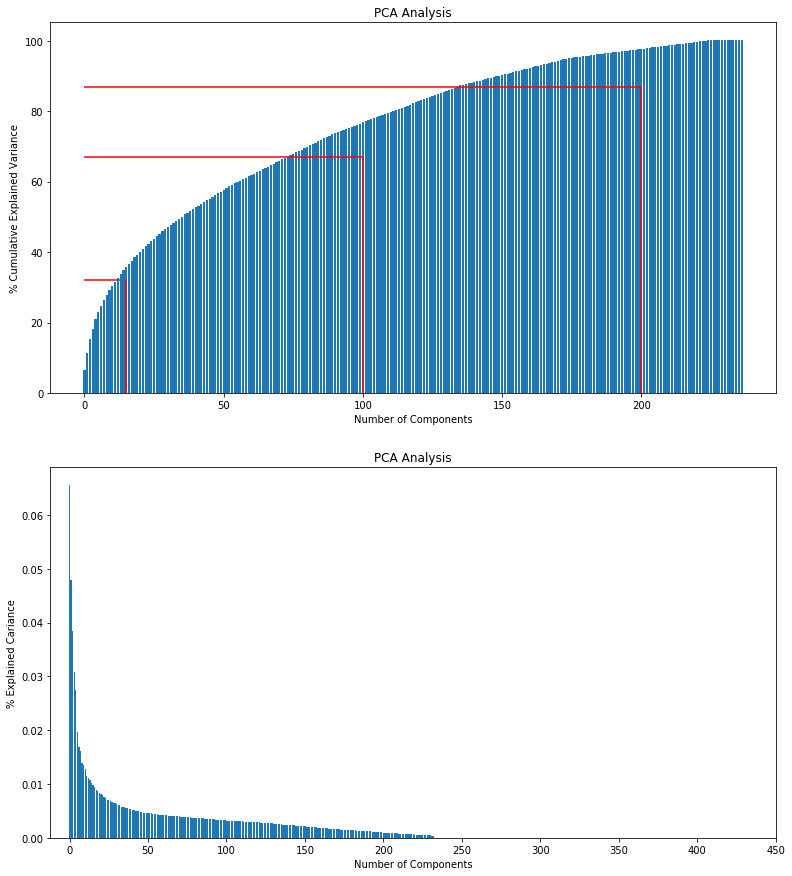

In [12]:
n_components = len(pca.explained_variance_ratio_)
index = np.arange(n_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(13,15))
plt.subplot(2, 1, 1)
plt.bar(index, cumsum_variance)
plt.ylabel('% Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.xticks(np.linspace(0,500, 10, endpoint=False))
plt.title('PCA Analysis')

# 15 components
plt.hlines(y=32, xmin=0, xmax=15, color='red', linestyles='-',zorder=1)
plt.vlines(x=15, ymin=0, ymax=32, color='red', linestyles='-',zorder=2)

# 100 components
plt.hlines(y=67, xmin=0, xmax=100, color='red', linestyles='-',zorder=3)
plt.vlines(x=100, ymin=0, ymax=67, color='red', linestyles='-',zorder=4)

# 200
plt.hlines(y=87, xmin=0, xmax=200, color='red', linestyles='-',zorder=5)
plt.vlines(x=200, ymin=0, ymax=87, color='red', linestyles='-',zorder=6)

plt.subplot(2, 1, 2)
plt.bar(index, vals)
plt.xticks(np.linspace(0,500, 10, endpoint=False))
plt.xlabel('Number of Components')
plt.ylabel('% Explained Cariance')
plt.title('PCA Analysis');

The plots above show that the explained variance plateaus a couple of times. The first and sharpest drop-off is around 15 components. At 15 components around 32 % of the total variance is explained. After this we can observe two other, but not as steep drop-offs around 100 and 200 components. At 100 components 76 % of the total variance is explained and at 200 87 %.
With each consecutive component less and less variance is explained which means that after a while the amount of additional explained variance probably is not worth the extra number of components.
With that said 100 components could be considered a good middle point

In [14]:
n_components = 100
print(f'{n_components} has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n_components])}')

100 has a cumulative explained variane of: 0.7635589741542947


In [36]:
azdias_cleaned.shape

(660764, 237)

In [15]:
# re-fit with n components
# apply PCA
pca = PCA(n_components=n_components)

# fit transform
azdias_pca = pca.fit_transform(azdias_cleaned)

In [16]:
from utils import * 
dim1 = interpret_pca(azdias_cleaned, pca, 0)
dim1

,Explained Variance,KBA05_ANTG1,KBA13_ANTG1,MOBI_RASTER,KBA05_GBZ,FINANZ_MINIMALIST,KBA13_AUTOQUOTE,KBA13_SEG_GELAENDEWAGEN,KBA05_ANHANG,GREEN_AVANTGARDE,...,KBA13_KW_0_60,KBA13_ALTERHALTER_30,EWDICHTE,KBA05_ANTG3,ZABEOTYP,ANZ_HAUSHALTE_AKTIV,FINANZ_HAUSBAUER,ARBEIT,CAMEO_DEUG_2015,HH_EINKOMMEN_SCORE
Dimension: 1,0.0656,0.169371,0.165369,0.157935,0.155845,0.145108,0.142028,0.125688,0.117684,0.117038,...,-0.105341,-0.110052,-0.110371,-0.111167,-0.112541,-0.119472,-0.133038,-0.135945,-0.17291,-0.182732


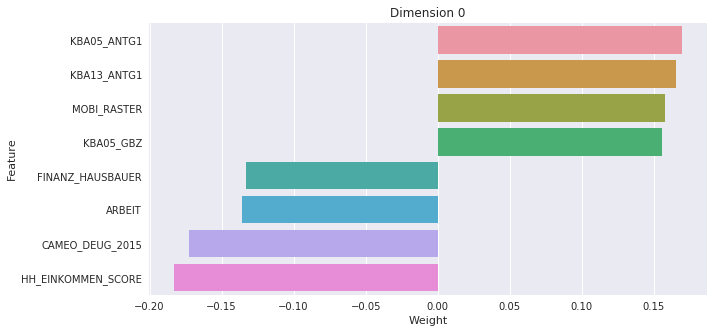

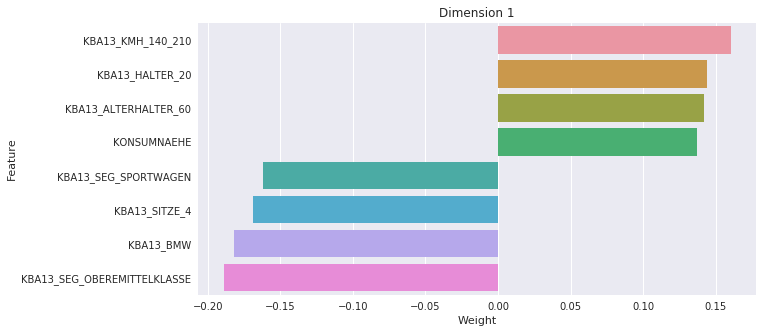

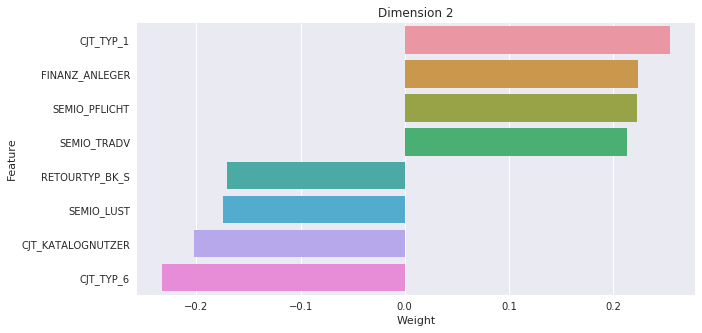

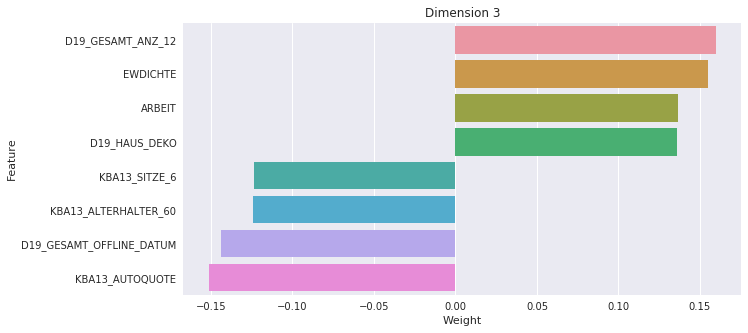

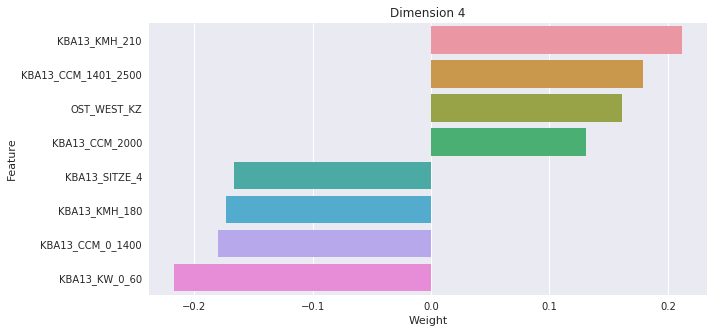

In [17]:
'''visualizing which feature is most dominant of in which cluster'''
for i in range(5):
    dim = interpret_pca(azdias_cleaned, pca, i)
    plot_pca(dim, i)

# CLUSTERING

## '''WILL APPLY CLUSTERING TO GENERAL POPULATION'''

In [18]:
%%time
# Number of different cluster counts
n_clusters = np.arange(2,31)

# run k-means clustering on the data and compute the average within-cluster distances.
scores = [MiniBatchKMeans(i).fit(azdias_pca).score(azdias_pca) for i in n_clusters]

CPU times: user 2min 12s, sys: 7.63 s, total: 2min 19s
Wall time: 2min 24s


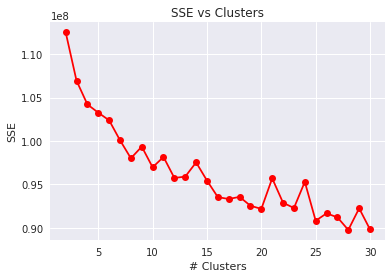

In [19]:
# elbow method
plt.ylabel('SSE')
plt.xlabel('# Clusters')
plt.title('SSE vs Clusters')
plt.plot(n_clusters, np.abs(scores), linestyle='-', marker='o', color='red');

In [20]:
%%time
# re-fith with 13 clusters
kmeans = KMeans(n_clusters=13, random_state=42, n_jobs=-1)

# general population predictions
azdias_predictions = kmeans.fit_predict(azdias_pca)

CPU times: user 6min 35s, sys: 1min 47s, total: 8min 23s
Wall time: 8min 26s


In [33]:
pca.transform,pca.n_features_,pca.n_components_

(<bound method _BasePCA.transform of PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False)>, 237, 100)

In [34]:
customers_cleaned.shape

(171749, 256)

In [66]:
pca = PCA(n_components=n_components)
customers_pca= pca.fit_transform(customers_cleaned)

In [68]:
customers_pca.shape

(171749, 100)

In [71]:
%%time
#kmeans_file = 'models/kmeans.save'
#joblib.dump(kmeans, kmeans_file)
customers_preds =  kmeans.predict(customers_pca)

CPU times: user 171 ms, sys: 0 ns, total: 171 ms
Wall time: 175 ms


In [72]:
customers_preds

array([10,  5,  5, ...,  9, 10,  4], dtype=int32)

In [73]:
azdias_predictions2=azdias_predictions.copy()

In [74]:
azdias_predictions

,Clusters
0,4
1,10
2,2
3,4
4,4
5,4
6,11
7,11
8,5
9,4


In [75]:
customers_preds=pd.DataFrame(customers_preds).rename(columns={0:'Clusters'})
azdias_predictions=pd.DataFrame(azdias_predictions).rename(columns={0:'Clusters'})

In [76]:
# azdias_predictions = clusters_predict(azdias_cleaned)
# customers_preds = clusters_predict(customers_cleaned)

**Compare Customer Data to Demographics Data**
At this point, we have clustered data based on demographics of the general population of Germany, now its time to see how the customer data for a mail-order sales company maps onto those demographic clusters. Let's end this section with a comparison of the two 
cluster distributions to see where the strongest customer base for the company is.

In [77]:
general_proportions = Counter(azdias_predictions['Clusters'])
customers_proportions = Counter(customers_preds['Clusters'])

In [78]:
for k, v in general_proportions.items():
    general_proportions[k] = v / len(azdias)
    
for k, v in customers_proportions.items():
    customers_proportions[k] = v / len(customers)

In [79]:
df_props = pd.DataFrame(columns=["Dataset", "Cluster", "Proportions", 'Difference'])
for k, v in customers_proportions.items():
    df_props = df_props.append({"Dataset" : "customer", "Cluster": k, "Proportions": v}, ignore_index=True)

for k, v in general_proportions.items():
    df_props = df_props.append({"Dataset" : "general", "Cluster": k, "Proportions": v}, ignore_index=True)

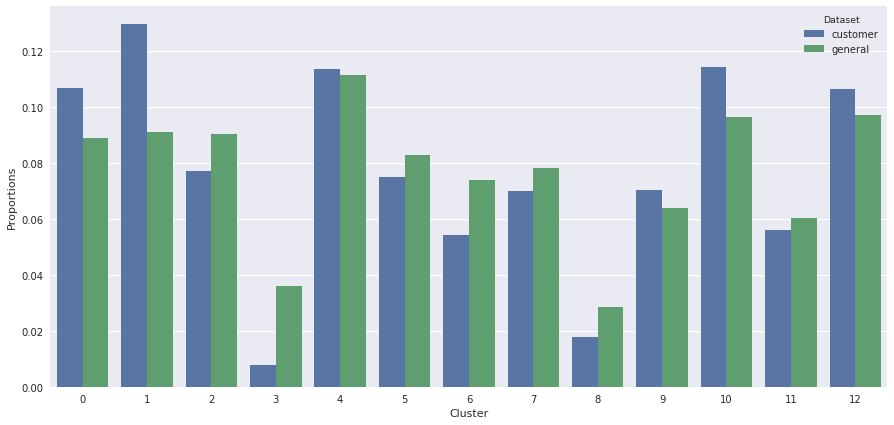

In [80]:
fig = plt.figure(figsize=(15,7))
sns.barplot(x="Cluster", y="Proportions", hue="Dataset", data=df_props);

In [82]:
df_difference = pd.DataFrame(columns=['Cluster', 'Difference'])

for k, v in general_proportions.items():
    diff = customers_proportions[k] - v
    df_difference = df_difference.append({"Cluster": k, "Difference": diff}, ignore_index=True)

df_difference

,Cluster,Difference
0,4.0,0.001898
1,10.0,0.018116
2,2.0,-0.013201
3,11.0,-0.004326
4,5.0,-0.007553
5,0.0,0.017679
6,12.0,0.008980
7,6.0,-0.019653
8,1.0,0.038620
9,3.0,-0.028078


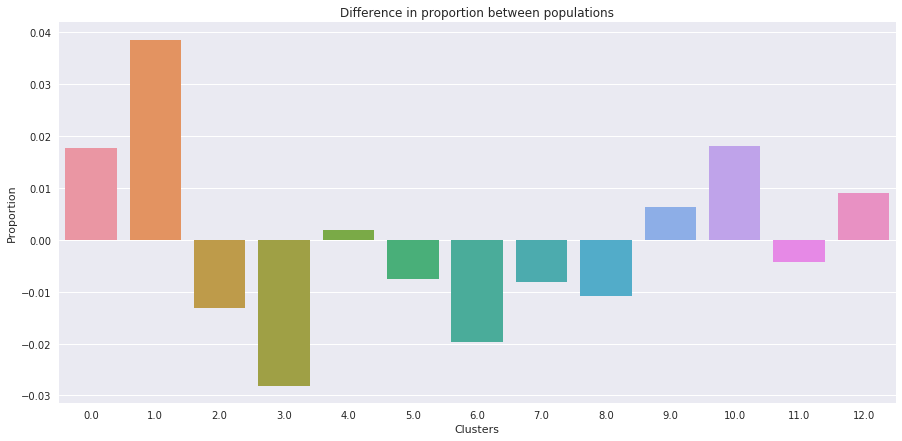

In [83]:
fig = plt.figure(figsize=(15,7))
ax = sns.barplot(x = df_difference['Cluster'], y = df_difference['Difference'])
ax.set(title=f'Difference in proportion between populations', ylabel='Proportion', xlabel='Clusters');

In [84]:
# center_target = kmeans.cluster_centers_
# center_general = kmeans.cluster_centers_

# center_target.shape, center_general.shape#,center_target,center_general

In [85]:
# # Due to large scale in some of the features no reversing of the scaler is applied.
# center_target_inv = pca.inverse_transform(center_target)
# center_general_inv = pca.inverse_transform(center_general)

In [86]:
# features = azdias_cleaned.columns

# plt.figure(figsize=(10,100))

# sns.barplot(x=center_target_inv, y=features, label="C7 Target", color="#5499C7")
# sns.barplot(x=center_general_inv, y=features, label="C2 General", color="#E59866")
          
# plt.legend(loc="upper left");

In [87]:
df_preds_azdias = pd.DataFrame(azdias_predictions['Clusters'].values, columns = ['Cluster'])
df_preds_customers = pd.DataFrame(customers_preds['Clusters'].values, columns = ['Cluster'])

In [88]:
target = df_preds_customers[df_preds_customers['Cluster'] == 7].index
general = df_preds_azdias[df_preds_azdias['Cluster'] == 2].index

df_target = customers_cleaned.iloc[target]
df_general = azdias_cleaned.iloc[general]

In [89]:
cols_to_visualize = ['KKK','LP_STATUS_GROB_1.0',
        'LP_STATUS_GROB_5.0','MOBI_REGIO','EWDICHTE'
,'ALTERSKATEGORIE_GROB',# (Estimated age)
'ANREDE_KZ',# (gender)
'FINANZTYP',# (financial type for individual)
'HH_EINKOMMEN_SCORE' ,#(Estimated household net income)
'LP_STATUS_FEIN' # (Social status, fine scale)
                    ]
'''HH_EINKOMMEN_SCORE: estimated household net income (lower = higher income)
LP_STATUS_GROB: social status (lower = lower status)
KKK: purchasing power (lower = higher purchasing power)
MOBI_REGIO: moving patterns (lower = higher mobility)
ANREDE_KZ: gender (1 = male & 2 = female)
EWDICHTE: density of inhabitants per square kilometer (lower = less dense)'''

'HH_EINKOMMEN_SCORE: estimated household net income (lower = higher income)\nLP_STATUS_GROB: social status (lower = lower status)\nKKK: purchasing power (lower = higher purchasing power)\nMOBI_REGIO: moving patterns (lower = higher mobility)\nANREDE_KZ: gender (1 = male & 2 = female)\nEWDICHTE: density of inhabitants per square kilometer (lower = less dense)'

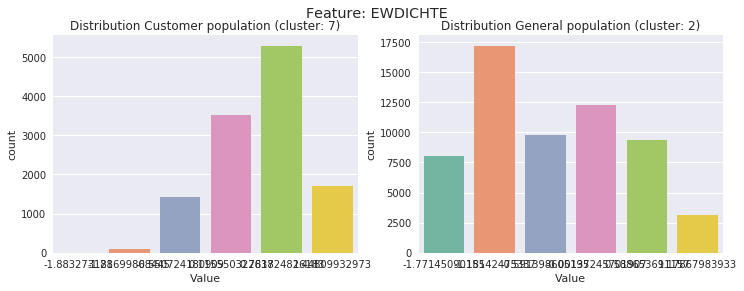

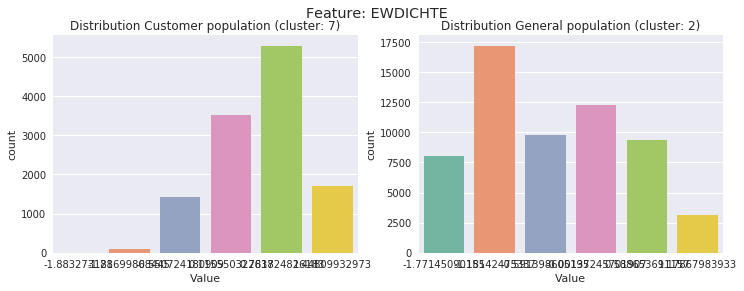

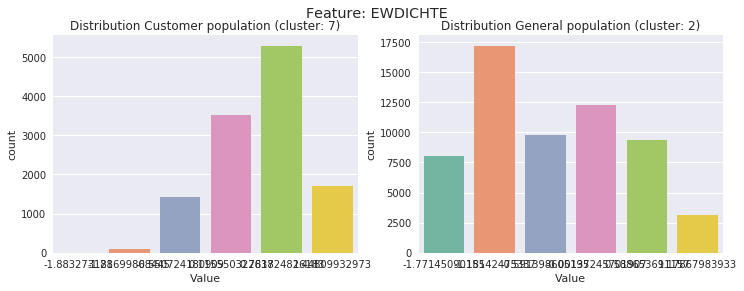

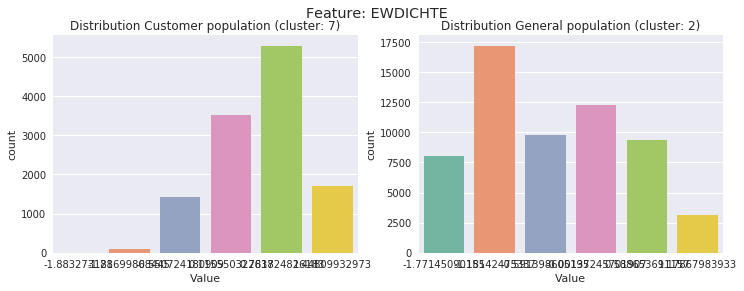

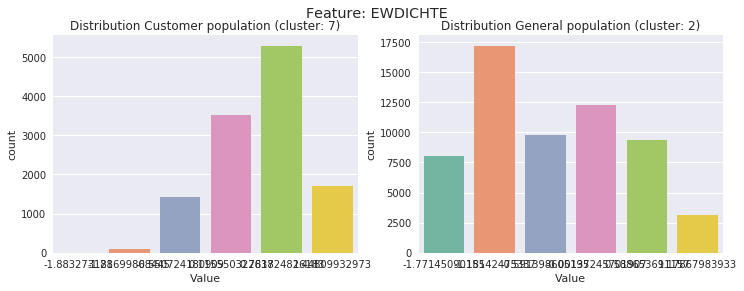

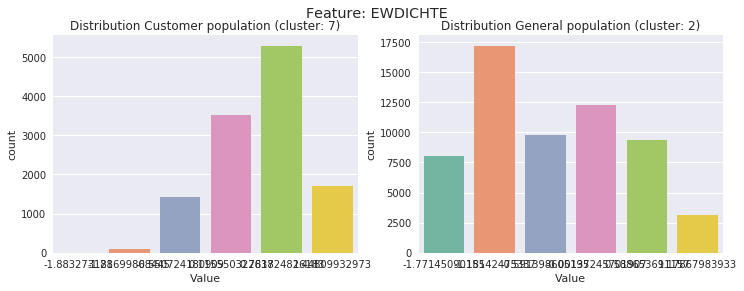

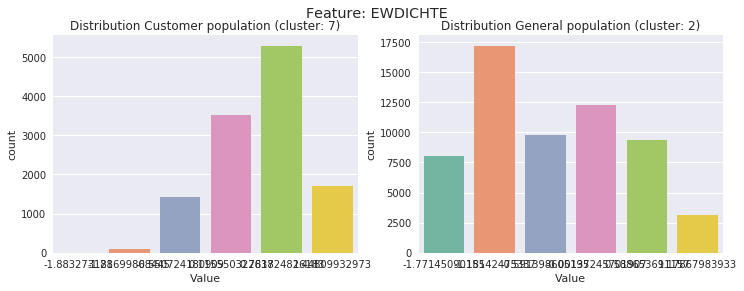

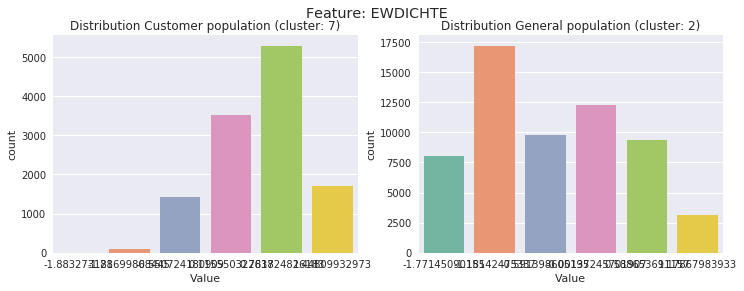

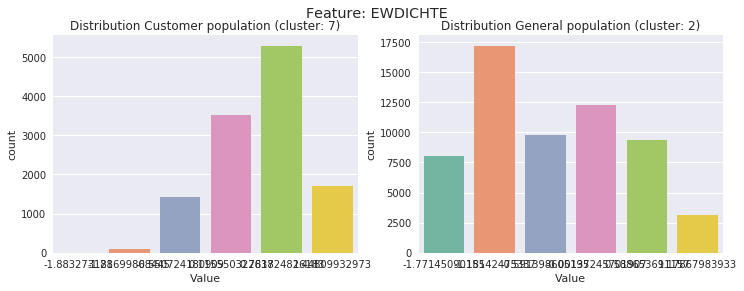

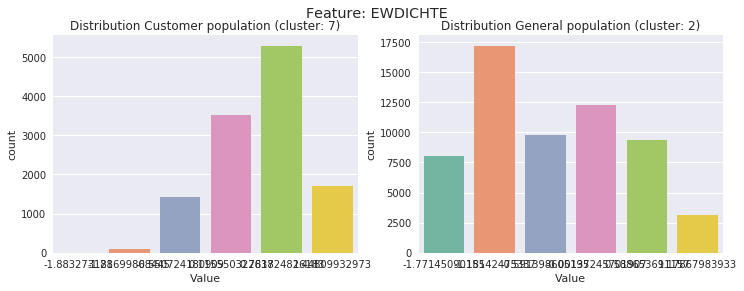

In [90]:
for col in cols_to_visualize:
    plot_comparison(column='EWDICHTE',
                customer=df_target,
                general=df_general)

# # THIS SUMS UP THE FIRST PART OF CLUSTERING AND SUGGESTING WHICH CLUSTER SEGMENT TO TARGET 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
def clean_and_data_preprocess(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']

    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    for col in df.columns:
    # fillna with 9 for fields that has 9 marked as unknown
        df.loc[(df[col]==9)&(df[col].isnull()),col] = 9#df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
        df.loc[(df[col]==0)&(df[col].isnull()),col] = 0#df[df.columns[(df==9).any()]].fillna(9)

    # fillna with -1 for fields that has 0 marked as unknown
        df.loc[(df[col]==-1)&(df[col].isnull()),col] = -1#df[df.columns[(df==9).any()]].fillna(9)


    df_col=df[df.columns[df.dtypes==object]].columns

    for col in df_col:

        unique_value=df[col].unique()

        q=1
        for unique_valu in unique_value:
            df.loc[df[col]==unique_valu,col]=q
            q+=1
#     df=df.astype(int)       
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)

    df_columns = list(df.columns.values)

    # impute nans using mean value
    cols= df[df.columns[df.isnull().sum()>0]].columns
    df_cols=df.columns
    for col in df_cols:
        df.loc[df[col].isnull(),col]=df[col].mean()
        
    #azdias.loc[azdias[col].isnull(),col]=azdias[col].mean()
    #imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    #df = imputer.fit_transform(df)
    #df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after removing nans', df.shape)



    # convert to int
    df = df.astype(int)


    # detect and exclude outliers in dataframe
    # as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns

    df = df.set_index('LNR')
    return df

In [3]:
!pip install lightgbm

    100% |████████████████████████████████| 1.2MB 10.7MB/s ta 0:00:01


In [4]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import random
import re
#import progressbar
from timeit import default_timer as timer

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.ensemble import GradientBoostingClassifier as xgb
#import xgboost as xgb
import lightgbm as lgb

#from skopt import BayesSearchCV

from utils import *

import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [5]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#mailout_train = pd.read_csv('mailout_train.csv', sep='\t')

In [7]:
#mailout_train.drop(columns=['Unnamed: 0'],inplace=True)
#mailout_train.columns

In [8]:
target = mailout_train['RESPONSE']
mailout_train_dropped = mailout_train.drop('RESPONSE', axis=1)

In [9]:
target.shape,mailout_train_dropped.shape

((42962,), (42962, 366))

In [10]:
mailout_train_cleaned = clean_and_data_preprocess(mailout_train_dropped, False)
#mailout_test_cleaned = clean_and_data_preprocess(mailout_test, False)

shape after corr (42962, 253)
shape after one-hot (42962, 253)
shape after removing nans (42962, 253)
shape after scaling (42962, 253)


Text(0.5,1,'Distribution of Label')

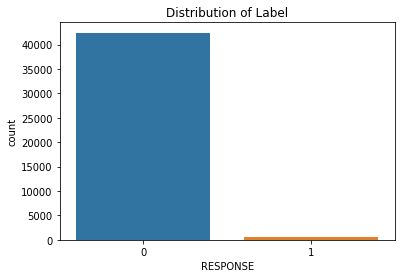

In [11]:
sns.countplot(target).set_title("Distribution of Label")

In [12]:
'''REPRESENTATION OF OUTPUT LABELS IN PERCENTAGE JUST TO UNDERSTAND THAT TO MUCH EXTENT OUR DATA IS IMBALANCED'''
print(target.value_counts(normalize=True)*100)

0    98.761696
1     1.238304
Name: RESPONSE, dtype: float64


In [13]:
!conda install -c conda-forge imbalanced-learn  --yes
#!pip install scikit-learn==0.22.2

Solving environment: - ^C
\ 

In [14]:
from imblearn.over_sampling import SMOTE # doctest: +
#SMOTE.fit_sample?


/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
# from imblearn.over_sampling import SMOTE # doctest: +
# from collections import Counter


# sm = SMOTE(random_state=42)
# mailout_train_cleaned, target = sm.fit_sample(mailout_train_cleaned, target)
# print('Resampled dataset shape %s' % Counter(target))
#mailout_train_cleaned=pd.read_pickle('mailout_train_cleaned.pkl')
#target = pd.read_pickle('target,pkl')


In [16]:
#mailout_train_cleaned2['RESPONSE']

In [17]:
# #mailout_train_cleaned.sample(5)
# mailout_train_cleaned2=pd.concat([mailout_train_cleaned,target])
# mailout_train_cleaned = mailout_train_cleaned.append(mailout_train_cleaned2[\
#                                                                             mailout_train_cleaned2['RESPONSE']==1]\
#                                                      .sample(int(mailout_train_cleaned2[\
#                                                     mailout_train_cleaned2['RESPONSE']==1].shape[0]*.3) ))

In [18]:
# mailout_train_cleaned,target = pd.concat([mailout_train_cleaned.sample(
#                                             int(mailout_train_cleaned[mailout_train_cleaned['RESPONSE']==0].shape[0]*.7)
#                                                                     )
#                                              ,mailout_train_cleaned.sample(
#                                             int(mailout_train_cleaned[mailout_train_cleaned['RESPONSE']==1].shape[0]*.3)
#                                                                     )
#                                             ]),pd.concat([target])

Text(0.5,1,'Distribution of Label')

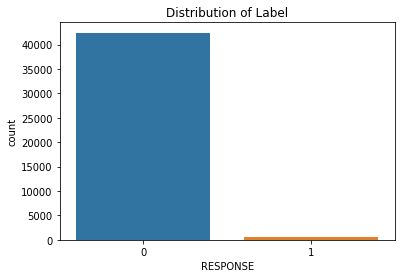

In [19]:
sns.countplot(target).set_title("Distribution of Label")

In [21]:
print(target.value_counts(normalize=True)*100)

0    98.761696
1     1.238304
Name: RESPONSE, dtype: float64


In [22]:
SEED=43

In [23]:
# 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=43, shuffle=True)
skf.get_n_splits(mailout_train_cleaned, target)

5

In [24]:
def create_base_models():
    '''
    Creates base models.
    
    Args:
        None
    
    Returns:
        baseModels (list) - list containing base models.
    '''
    basedModels = []
    basedModels.append(('LR', LogisticRegression(solver='liblinear', random_state=SEED)))
    #basedModels.append(('RF', RandomForestClassifier(n_estimators=100, random_state=SEED)))
    basedModels.append(('XGB', xgb(random_state=SEED)))
    basedModels.append(('LGBM', lgb.LGBMClassifier(random_state=SEED)))
    basedModels.append(('GB', GradientBoostingClassifier(random_state=SEED)))
    #basedModels.append(('MLP', MLPClassifier(random_state=SEED)))
    
    return basedModels

In [25]:
def evaluate(features, response, models, curve=False):
    '''
    Evaluates models using X-Fold cross-validation. 
    Learning curve can also be plotted (optional).
    
    Args:
        features (dataframe) - dataset to be used for training.
        response (dataframe) - target variable
        models (list) - list of models to evaluated.
        curve (bool) - whether or not to plot learning curve.
        
    Returns:
        names (list) - list of models tested.
        results (list) - list of results for each model.
    '''
    results = []
    names = []
    for name, model in models:
        cv_results = cross_val_score(model, features, response, cv=skf, scoring='roc_auc', n_jobs=-1)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        if curve:
            train_sizes, train_scores, test_scores = learning_curve(
                model, features, response, cv=skf, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, 10), n_jobs=-1)

            train_scores_mean = np.mean(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            print("roc auc train score = {}".format(train_scores_mean[-1].round(2)))
            print("roc auc validation score = {}".format(test_scores_mean[-1].round(2)))
            plt.grid()

            plt.title("Learning Curve")
            plt.xlabel("% of training set")
            plt.ylabel("Score")

            plt.plot(np.linspace(.1, 1.0, 10)*100, train_scores_mean, 'o-', color="g",
                     label="Training score")
            plt.plot(np.linspace(.1, 1.0, 10)*100, test_scores_mean, 'o-', color="r",
                     label="Cross-validation score")

            plt.yticks(np.arange(0.45, 1.02, 0.05))
            plt.xticks(np.arange(0., 100.05, 10))
            plt.legend(loc="best")
            print("")
            plt.show()
        
        
    return names, results

In [26]:
def get_scaled_preprocess(type_of_scaler):
    '''
    Create machine learning pipeline with or without scaler.
    
    Args:
        type_of_scaler (str) - string value representing which scaler to use (if any).
        
    Returns (pipeline) - ml pipeline created.
    '''
    
    if type_of_scaler == 'standard':
        scaler = StandardScaler()
    elif type_of_scaler == 'minmax':
        scaler = MinMaxScaler()
        
    pipelines = []
    pipelines.append((type_of_scaler+'LR', Pipeline([('Scaler', scaler), ('LR', LogisticRegression(solver='liblinear', random_state=SEED))])))
    #pipelines.append((type_of_scaler+'RF', Pipeline([('Scaler', scaler), ('RF', RandomForestClassifier(n_estimators=100, random_state=SEED))])))   
    pipelines.append((type_of_scaler+'XGB', Pipeline([('Scaler', scaler), ('XGB', xgb(random_state=SEED))])))
    pipelines.append((type_of_scaler+'LGBM', Pipeline([('Scaler', scaler), ('LGBM', lgb.LGBMClassifier(random_state=SEED))])))
    pipelines.append((type_of_scaler+'GB', Pipeline([('Scaler', scaler), ('GB', GradientBoostingClassifier(random_state=SEED))])))   
    #pipelines.append((type_of_scaler+'MLP', Pipeline([('Scaler', scaler), ('MLP', MLPClassifier(random_state=SEED))])))   

    
    return pipelines

In [27]:
def create_score_df(names, results):
    '''
    Creates a dataframe containing model names and corresponding score.
    
    Args:
        names (list) - list of model names.
        results (list) - list of scores.
    '''
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

LR: 0.662694 (0.013814)
roc auc train score = 0.79
roc auc validation score = 0.66



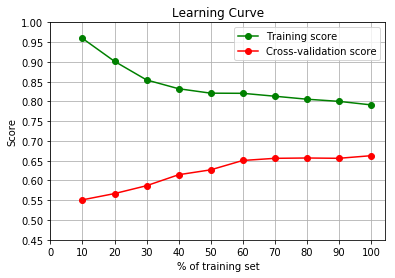

XGB: 0.756156 (0.005079)
roc auc train score = 0.91
roc auc validation score = 0.76



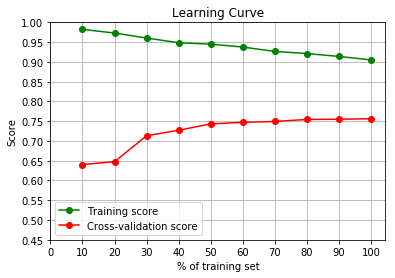

LGBM: 0.705041 (0.015993)
roc auc train score = 0.98
roc auc validation score = 0.7



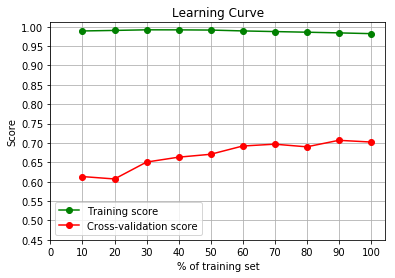

GB: 0.756156 (0.005079)
roc auc train score = 0.91
roc auc validation score = 0.76



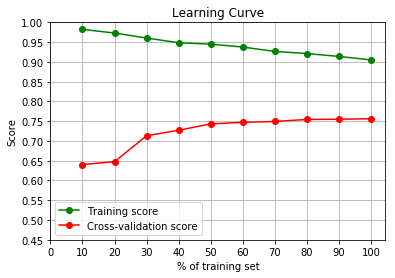

In [29]:
#scaled 
models = create_base_models()
names, results = evaluate(mailout_train_cleaned, target, models, curve=True)
#baseline_score = create_score_df(names, results)
#baseline_score

In [30]:
baseline_score = create_score_df(names, results)
baseline_score

,Model,Score
0,LR,0.6627
1,XGB,0.7562
2,LGBM,0.7050
3,GB,0.7562


In [ ]:
results

In [ ]:
model2=xgb(random_state=SEED)#models[0][1]


In [ ]:
# # standard scaler
# models = get_scaled_preprocess('standard')
# names, results = evaluate(mailout_train_cleaned, target, models)
# standard_scaler_score = create_score_df(names, results)

# df_score = pd.concat([baseline_score, standard_scaler_score], axis=1)
# df_score
model2

In [ ]:
# #scaler = MinMaxScaler()
# #scaler.fit(mailout_train_cleaned.astype('float'))

# mailout_train_cleaned_scaled =mailout_train_cleaned.copy()# mailout_scaler.transform(mailout_train_cleaned)
# #mailot_test_cleaned_scaled = scaler.transform(mailout_test_cleaned)

# # map back to dfs
# mailout_train_cleaned_scaled = pd.DataFrame(data=mailout_train_cleaned_scaled, columns=mailout_train_cleaned.columns)
# #mailot_test_cleaned_scaled = pd.DataFrame(data=mailot_test_cleaned_scaled, columns=mailout_test_cleaned.columns)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svc = svm.SVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(iris.data, iris.target)


In [70]:
from imblearn.over_sampling import SMOTE # doctest: +
from collections import Counter
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
#mailout_train.drop(columns=['Unnamed: 0'],inplace=True)
target = mailout_train['RESPONSE']
mailout_train_dropped = mailout_train.drop('RESPONSE', axis=1)
mailout_train_cleaned = clean_and_data_preprocess(mailout_train_dropped, False)

sm = SMOTE(random_state=42)
#mailout_train_cleaned, target = sm.fit_sample(mailout_train_cleaned, target)






/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


shape after corr (42962, 253)
shape after one-hot (42962, 253)
shape after removing nans (42962, 253)
shape after scaling (42962, 253)


In [71]:
# Split the dataset into Train/Validation/Test

X_train, X_val, y_train, y_val = train_test_split(mailout_train_cleaned,target, stratify=target, test_size=0.2, random_state=42)

In [72]:
mailout_train_cleaned.shape

(42962, 252)

In [73]:
class_weights = {0:1 ,
                1: 1,
                #2: 2.
               }
from sklearn.utils import class_weight
class_weights,y_train.value_counts(),y_val.value_counts()

({0: 1, 1: 1}, 0    33943
 1      426
 Name: RESPONSE, dtype: int64, 0    8487
 1     106
 Name: RESPONSE, dtype: int64)

In [74]:
# #xgb?
# model?
# rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

# param_grid = { 
#     'n_estimators': [200, 700],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X, y)
# print CV_rfc.best_params_

In [75]:
class_weights = {0:1 ,
                1: 1,
                #2: 2.
               }

In [76]:

# from sklearn.utils import class_weight
# # class_weights = class_weight.compute_class_weight('balanced',
# #                                                  np.unique(y_train),
# #                                                  y_train)
# model=lgb.LGBMClassifier(random_state=SEED,class_weight=class_weights,boosting_type='dart',reg_lambda=1,n_estimatos=200)
# param_grid = { 
#     'n_estimators': [200, 700],
#     'max_features': ['auto', 'sqrt', 'log2']
#     #'objective': 'binary:logistic'
# }
# #from sklearn.utils.class_weight import compute_class_weight
# #class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
# CV_boosting = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
# CV_boosting.fit(X_train, y_train)
# print (CV_boosting.best_params_)

# #model.fit(X_train, y_train)
# #model.fit(X_train, y_train, class_weight=class_weight)


In [111]:
basedModels = []
basedModels.append(('LR', LogisticRegression(solver='liblinear', random_state=SEED)))
basedModels.append(('RF', RandomForestClassifier(n_estimators=100, random_state=SEED)))
basedModels.append(('XGB', xgb(random_state=SEED)))
basedModels.append(('LGBM', lgb.LGBMClassifier(random_state=SEED)))
basedModels.append(('GB', GradientBoostingClassifier(random_state=SEED)))
basedModels.append(('MLP', MLPClassifier(random_state=SEED)))

In [119]:
model_fit=[]
for name,models in basedModels:
    print(name)
    model_fit.append((name,models.fit(X_train,y_train)))

LR
RF
XGB
LGBM
GB
MLP


In [120]:
result=[]
for name,model in model_fit:
    best_predictions=model.predict(X_val)
    score=roc_auc_score(y_val, best_predictions)
    result.append((name,score)\
                  )
    

In [121]:
result

[('LR', 0.5),
 ('RF', 0.5),
 ('XGB', 0.49982325910215625),
 ('LGBM', 0.49988217273477081),
 ('GB', 0.49982325910215625),
 ('MLP', 0.49958760457169787)]

In [139]:
# #lgb.LGBMClassifier?
# 'gbdt', traditional Gradient Boosting Decision Tree.
# 'dart', Dropouts meet Multiple Additive Regression Trees.
# 'goss', Gradient-based One-Side Sampling.
# 'rf', Random Forest.


In [144]:
#setting solver to liblinear as this will 
# model1=RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True,class_weight='balanced')
model_type=[]
model_type_fit=[]
q=0
for boosting_type in ['gbdt','dart','goss']:
    print(boosting_type)
    model_type.append(lgb.LGBMClassifier(random_state=SEED,boosting_type=boosting_type,\
                              class_weight='balanced',
                             reg_lambda=.5,
                             reg_alpha=0.5,
                             #n_estimators=500,\
                             max_features='auto',#learning_rate=0.05
                            #colsample_bytree': 0.6872852588903648, 
                             gamma= 1.0, \
                            learning_rate=0.01900, max_depth= 7, min_child_weight= 1, \
                            n_estimators= 400, scale_pos_weight= 1, subsample= 0.5
                            ))

    model_type_fit.append(model_type[q].fit(X_train, y_train))
    q+=1


gbdt
dart
goss


In [191]:
#model1.evals_result_()
boosting_types=['gbdt','dart','goss']
q=0
model_preds=[]
for model_type_fits in model_type_fit:
    model_preds.append(model_type_fits.predict(X_val))
    print(boosting_types[q],roc_auc_score(y_val, model_preds[q]) )
    q+=1
    
    


gbdt 0.551434936006
dart 0.700025121662
goss 0.534570074987


In [193]:
from scipy import stats
#m = stats.mode(a)
pred = stats.mode(model_preds)


In [194]:
a  = pred[0]
#len(a[0]),len(model_preds[0]),a[0]

In [195]:
print(roc_auc_score(y_val,a[0]) )

0.552440358284


In [ ]:
'Ebsembling all these models but result are not well so only using LGBM classifier with boosting type=dart'

In [140]:
# best_predictions=model1.predict(X_val)
# model1

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=1.0, gamma=1.0, importance_type='split',
               learning_rate=0.019, max_depth=7, max_features='auto',
               min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
               random_state=43, reg_alpha=0.5, reg_lambda=0.5,
               scale_pos_weight=1, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)

In [141]:
# roc_auc_score(y_val, best_predictions)

0.7000251216622092

In [206]:
model = model_type_fit[1]
model

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=1.0, gamma=1.0, importance_type='split',
               learning_rate=0.019, max_depth=7, max_features='auto',
               min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
               random_state=43, reg_alpha=0.5, reg_lambda=0.5,
               scale_pos_weight=1, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)

In [198]:
from sklearn.metrics import classification_report

print(classification_report(y_val, model_preds[1]))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      8487
           1       0.04      0.60      0.07       106

    accuracy                           0.79      8593
   macro avg       0.51      0.70      0.48      8593
weighted avg       0.98      0.79      0.87      8593



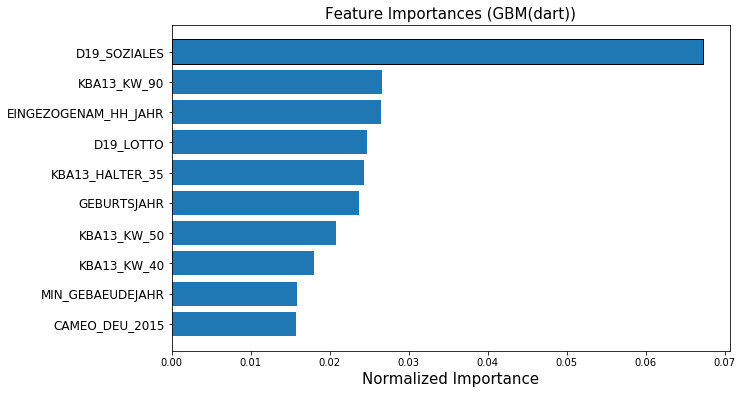

In [208]:
plot_feature_importances(model=model, model_type="GBM(dart)", features=mailout_train_cleaned.columns)

In [ ]:
# mailout_train = pd.read_csv('mailout_train.csv', sep='\t')
# mailout_train.drop(columns=['Unnamed: 0'],inplace=True)
# target = mailout_train['RESPONSE']
# mailout_train_dropped = mailout_train.drop('RESPONSE', axis=1)
# mailout_train_cleaned = clean_and_data_preprocess(mailout_train_dropped, False)


In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(mailout_train_cleaned,target, stratify=target, test_size=0.2, random_state=42)

In [ ]:
# class_weights2 = {0:1 ,
#                 1: 1000,
#                 #2: 2.
#                }
# model2=lgb.LGBMClassifier(random_state=SEED,class_weight=class_weights2,boosting_type='dart',\
#                          reg_lambda=0.5,
#                          reg_alpha=0.5,
#                          #n_estimators=500,\
#                          max_features='auto',#learning_rate=0.05
#                         #colsample_bytree': 0.6872852588903648, 
#                          gamma= 1.0, \
#                         learning_rate=0.0200, max_depth= 7, min_child_weight= 1, \
#                         n_estimators= 400, reg_alpha= 1e-09, scale_pos_weight= 1, subsample= 0.5
#                         )

# model2.fit(X_train, y_train)



In [ ]:
# best_predictions=model2.predict(X_val)

In [ ]:
# roc_auc_score(y_val, best_predictions)

In [ ]:
# # %%time
# result_rf = model.fit(mailout_train_cleaned, target)

In [ ]:
# result_rf

In [ ]:
# Split the dataset into Train/Validation/Test

# X_train, X_val, y_train, y_val = train_test_split(mailout_train_cleaned,target, stratify=target, test_size=0.2, random_state=42)

In [ ]:
# sorted(alg_xgb.get_params().keys())

In [ ]:
# cross_val_score(model, features, response, cv=skf, scoring='roc_auc', n_jobs=-1)

In [ ]:
# parameters = { 'learning_rate' : [0.1],
#                 'n_estimators' :[500],
#                 #'reg_alpha' : [0.05],
#                 'subsample' : [0.6],
#                 #'colsample_bytree' : [0.7],
#                 #'gamma' : [0.2],
#                 'max_depth' : [3],
#                 #'min_child_weight' : [2],
#                 #'objective' : ['binary:logistic'],
#                 #'scale_pos_weight' : [1],
#                 'random_state' : [42]
#                 #'scoring' : ['roc_auc']
#              }

# # Perform grid search on the classifier using 'scorer' as the scoring method
# cv = GridSearchCV(model, parameters, scoring = 'roc_auc', n_jobs= -1)

# # Fit the grid search object to the training data and find the optimal parameters
# grid_fit2 = cv.fit(X_train, y_train)



In [ ]:
# grid_fit2.best_estimator_#, cv.best_params_, cv.best_score_

In [ ]:
# #print(cv.grid_scores_, cv.best_params_, cv.best_score_)

# # Get the estimator and predict
# best_clf = grid_fit2.best_estimator_
# #predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

# best_predictions = best_clf.predict(X_val)

In [ ]:
# roc_auc_score(y_val, best_predictions)

In [ ]:
# cv = StratifiedKFold(n_splits=2,shuffle=True, random_state=42)

# roc_score = []
# for train,test in cv.split(X_train,y_train):
#     preds = alg_test.fit(X_train,y_train)
#     predictions_test = preds.predict(X_val)
#     roc_score.append(roc_auc_score(y_val, predictions_test))
    
# print(roc_score)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [209]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#mailout_test=pd.read_csv('mailout_test.csv',sep='\t')
#mailout_train.drop(columns=['Unnamed: 0'],inplace=True)



In [211]:
mailout_test.columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=366)

In [213]:
#del mailout_test['Unnamed: 0']

In [214]:
mailout_tes_cleaned= clean_and_data_preprocess(mailout_test,False)

shape after corr (42833, 253)
shape after one-hot (42833, 253)
shape after removing nans (42833, 253)
shape after scaling (42833, 253)


In [215]:
mailot_test_cleaned_scaled = mailout_tes_cleaned.copy()
#mailot_test_cleaned_scaled = pd.DataFrame(data=mailot_test_cleaned_scaled, columns=mailout_tes_cleaned.columns)


In [216]:
model

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=1.0, gamma=1.0, importance_type='split',
               learning_rate=0.019, max_depth=7, max_features='auto',
               min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
               random_state=43, reg_alpha=0.5, reg_lambda=0.5,
               scale_pos_weight=1, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)

In [220]:
preds =(model.predict(mailot_test_cleaned_scaled.values))
#preds2 = pd.DataFrame(model2.predict(mailot_test_cleaned_scaled.values))
#preds1.loc[preds2[0]==1,0]=1
#preds1
preds

array([1, 1, 0, ..., 0, 0, 0])

In [221]:
# create submission file
kaggle_sub = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=preds)
kaggle_sub.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_sub.to_csv('kaggle_sub5.csv')

In [222]:
kaggle_sub

,RESPONSE
LNR,
1754,1
1770,1
1465,0
1470,0
1478,0
1782,0
1485,0
1519,0
1835,1


In [226]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('Capture.JPG')

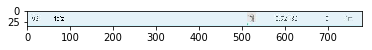

In [227]:
imgplot = plt.imshow(img)
# .721 score